In [23]:
!pip install pyLDAvis
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
!python -m spacy download en

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136900 sha256=fe91e4fb42a396fc05fa7e7a2f064eb374571ea81d38d9c9df010a7c21b5fdf9
  Stored in directory: c:\users\bpavu\appdata\local\pip\cache\wheels\90\61\ec\9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=35711b348134e9d84cef698f402a1730e32041be64a45eb6d21415649b42e7a1
  Stored in directory: c:\users\bpavu\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from pprint import pprint
import gensim
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
#plotting libraries!
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import the wordcloud library
from wordcloud import WordCloud

# Visualize the topics
import pyLDAvis
import warnings
warnings.filterwarnings('ignore')

C:\Anaconda\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Anaconda\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).

In [2]:
#reading the data set
data_df = pd.read_csv("data/cleaned_data.csv")

In [3]:
data_df['dish_reviewed'] = data_df['dish_reviewed'].fillna('')
data_df['cuisines'] = data_df['cuisines'].fillna('')
data_df['reviews_list'] = data_df['reviews_list'].fillna('')
data_df['menu_item'] = data_df['menu_item'].fillna('')

In [4]:
import numpy as np
data_df['online'] = np.where(data_df['online_order'] == 'Yes', 'Online', '')
data_df['table_booking'] = np.where(data_df['book_table'] == 'Yes', 'TableBooking', '')

In [5]:
max(data_df.reviews_list.apply(len))

2330716

In [6]:
data_df['reviews_list'] = data_df['reviews_list'].str[:1000000]

In [7]:
def weighted_rating(data, m, c):
    v = data['votes']
    R = data['rate']
    wr = (v/(v+m) * R) + (m/(m+v) * C)
    return round(wr,1)

In [8]:
# this is V
vote_counts = data_df[data_df['votes'].notnull()]['votes'].astype('int')

# this is R
vote_averages = data_df[data_df['rate'].notnull()]['rate'].astype('int')

# this is C
C = vote_averages.mean()
m = vote_counts.quantile(0.50)
print(C)
print(m)

3.163341512856076
53.0


In [9]:
data_df['weighted_rating'] = data_df.apply(lambda x: weighted_rating(x, m, C), axis =1)

In [10]:
print(data_df.nunique())

address            8758
name               6542
online_order          2
book_table            2
rate                 31
votes              1251
location            108
rest_type            64
dish_reviewed      4286
cuisines           1794
cost_for_two         63
reviews_list       9071
menu_item          6097
listed_as            55
listed_in_city      404
online                2
table_booking         2
weighted_rating      29
dtype: int64


In [11]:
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and special characters

data_words = list(sent_to_words(data_df['reviews_list']))


In [12]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(["good","nice","bad","would","also","really","go","make","get","come","much"]) #extend existing stop word list if needed


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bpavu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
import gensim

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(review):
    return [bigram_mod[doc] for doc in review]

In [14]:
def lemmatization(review, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    lemmatized = []
    for sent in review:
        doc = nlp(" ".join(sent)) 
        lemmatized.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return lemmatized

In [15]:
import spacy

data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

nlp.max_length = 2300000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'ADV'])
print(data_lemmatized[:1])

[['dinner', 'family', 'suitable', 'age', 'people', 'starter', 'service', 'price', 'affordable', 'restaurant', 'early', 'dinner', 'little', 'noisy', 'ambience', 'staff', 'courteous', 'price', 'pretty', 'high', 'quantity', 'overall', 'experience', 'fine', 'quality', 'little', 'expensive', 'quantity', 'term', 'decent', 'talk', 'ambience', 'regular', 'restaurant', 'family', 'dinner', 'lunch', 'quantity', 'price', 'bit', 'presentation', 'repeat', 'customer', 'quite', 'time', 'family', 'well', 'new', 'banashankari', 'part', 'delite', 'friendly', 'staff', 'tasty', 'well', 'ambience', 'friendly', 'staff', 'pocket', 'friendly', 'definitely', 'dine', 'ambiance', 'time', 'neat', 'restroom', 'table', 'thing', 'lunch', 'music', 'back', 'back', 'little', 'annoying', 'chicken', 'fresh', 'tender', 'rice', 'well', 'overall', 'great', 'mutton', 'tasty', 'plenty', 'mutton', 'piece', 'cool', 'ambience', 'slow', 'music', 'delicious', 'peace', 'staff', 'friendly', 'clean', 'price', 'average', 'quantity', 't

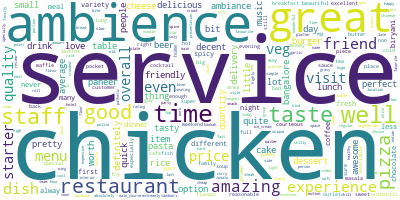

In [16]:
# Import the wordcloud library
from wordcloud import WordCloud
import itertools 

# Join the different processed titles together
list_of_words = list(itertools.chain.from_iterable(data_lemmatized))
long_string = ','.join(word for word in list_of_words)
long_string

# # Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', collocations = False,  random_state=1)

# # Generate a word cloud
wordcloud.generate(long_string)

# # Visualize the word cloud
wordcloud.to_image()

In [17]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 2), (1, 2), (2, 1), (3, 2), (4, 11), (5, 2), (6, 4), (7, 1), (8, 4), (9, 2), (10, 2), (11, 2), (12, 2), (13, 5), (14, 4), (15, 2), (16, 1), (17, 1), (18, 3), (19, 1), (20, 4), (21, 2), (22, 2), (23, 2), (24, 2), (25, 1), (26, 1), (27, 3), (28, 2), (29, 2), (30, 2), (31, 2), (32, 4), (33, 2), (34, 2), (35, 2), (36, 4), (37, 2), (38, 2), (39, 8), (40, 4), (41, 1), (42, 2), (43, 2), (44, 2), (45, 1), (46, 1), (47, 2), (48, 4), (49, 6), (50, 11), (51, 2), (52, 2), (53, 1), (54, 1), (55, 2), (56, 2), (57, 2), (58, 8), (59, 2), (60, 3), (61, 2), (62, 3), (63, 3), (64, 1), (65, 1), (66, 2), (67, 2), (68, 1), (69, 2), (70, 2), (71, 1), (72, 2), (73, 1), (74, 8), (75, 7), (76, 2), (77, 1), (78, 2), (79, 2), (80, 4), (81, 4), (82, 1), (83, 2), (84, 2), (85, 1), (86, 1), (87, 2), (88, 2), (89, 2), (90, 6), (91, 2), (92, 2), (93, 1), (94, 2), (95, 2), (96, 1), (97, 2), (98, 1), (99, 2), (100, 4), (101, 2), (102, 2), (103, 2), (104, 2), (105, 2), (106, 2), (107, 9), (108, 2), (109, 2), (110, 

In [18]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
# Takes lot of time to execute, so commenting it out

#topic_param = [1,5,10,15,20,25,30]
#coherence_score = []
#for k in topic_param:
#    cv = compute_coherence_values(corpus=corpus, dictionary=id2word, k=k)
#    coherence_score.append(cv)

#param_tuning_coherence = pd.DataFrame()
#param_tuning_coherence["topic_param"] = topic_param
#param_tuning_coherence['coherence_score'] = coherence_score
#param_tuning_coherence

In [20]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=4, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.027*"service" + 0.026*"ambience" + 0.023*"great" + 0.015*"music" + 0.015*"staff" + 0.015*"beer" + 0.015*"chicken" + 0.013*"well" + 0.013*"time" + 0.013*"friend"'), (1, '0.022*"ambience" + 0.022*"service" + 0.019*"chicken" + 0.017*"great" + 0.015*"staff" + 0.014*"well" + 0.012*"dish" + 0.010*"amazing" + 0.009*"pasta" + 0.009*"time"'), (2, '0.028*"pizza" + 0.023*"burger" + 0.016*"time" + 0.014*"cake" + 0.013*"chocolate" + 0.012*"good" + 0.012*"service" + 0.011*"well" + 0.011*"coffee" + 0.011*"cheese"'), (3, '0.028*"chicken" + 0.019*"service" + 0.017*"restaurant" + 0.016*"taste" + 0.015*"time" + 0.011*"well" + 0.010*"quality" + 0.010*"veg" + 0.009*"great" + 0.009*"rice"')]


In [21]:
# Evaluate base model- Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5431716906534154


In [22]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   

In [23]:
data_topic_df = data_df

In [25]:
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus))
for n in range(len(data_topic_df)):
    get_document_topics = lda_model.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
data_topic_df['Doc'] = doc_num
data_topic_df['Topic'] = topic_num
data_topic_df['Probability'] = prob

In [26]:
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.006675 -0.082372       1        1  25.296661
1     -0.011865 -0.042738       2        1  21.975987
2     -0.082587  0.074621       3        1  17.401444
3      0.101128  0.050488       4        1  35.325909, topic_info=            Term           Freq          Total Category  logprob  loglift
394        pizza  143621.000000  143621.000000  Default  30.0000  30.0000
421       burger   85503.000000   85503.000000  Default  29.0000  29.0000
1811        beer   66397.000000   66397.000000  Default  28.0000  28.0000
80         music   79623.000000   79623.000000  Default  27.0000  27.0000
14          cake   50795.000000   50795.000000  Default  26.0000  26.0000
...          ...            ...            ...      ...      ...      ...
49    experience   40265.864018  118632.488011   Topic4  -5.0552  -0.0400
7        awesome   33727.214044   80386.896317   Topic4  -5.2324   0.1720
4       ambience   47680.247362  267257.348816   Topic4  -4.8862  -0.6831
132        staff   37946.873730  174808.643990   Topic4  -5.1145  -0.4870
326        worth   31509.033183   80528.333308   Topic4  -5.3004   0.1022

[410 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
3323       4  0.998349  afghani
3445       1  0.867891  alcohol
3445       2  0.110351  alcohol
3445       3  0.007771  alcohol
3445       4  0.013988  alcohol
...      ...       ...      ...
756        1  0.008836     wrap
756        2  0.114864     wrap
756        3  0.744611     wrap
756        4  0.131733     wrap
15498      1  0.998728     xoox

[896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [27]:
pyLDAvis.save_html(LDAvis_prepared, 'lda.html')

In [28]:
data_topic_df.to_csv("data/data_topic.csv",index=False)

<AxesSubplot:xlabel='Topic', ylabel='count'>

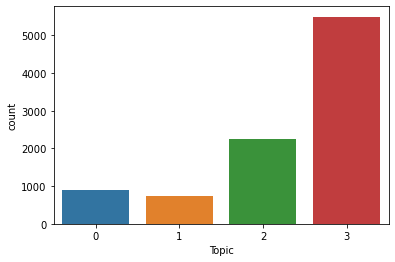

In [30]:
sns.countplot(x='Topic', data=data_topic_df)